In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import colorcet as cc
import matplotlib
import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "./data/nankai_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)


In [18]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
# initial_dip_slip_deficit = initial_slip_deficit[1::2]
initial_dip_slip_deficit = np.load(
    "./data/nankai_high_resolution_tde_dip_slip_rates.npy"
)
total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)


In [25]:

location_probability = skies.get_location_probability(pre_event_slip_deficit)
event = skies.create_event(meshes, location_probability)

event.hypocenter_longitude = 134.0
event.hypocenter_latitude = 32.5
event.hypocenter_depth = 10.0
event.moment_magnitude = 8.5
event.shear_modulus = 3e10
event.area_scaling = 1.2
event = skies.get_event_area_slip_hypocenter(meshes[0], event)

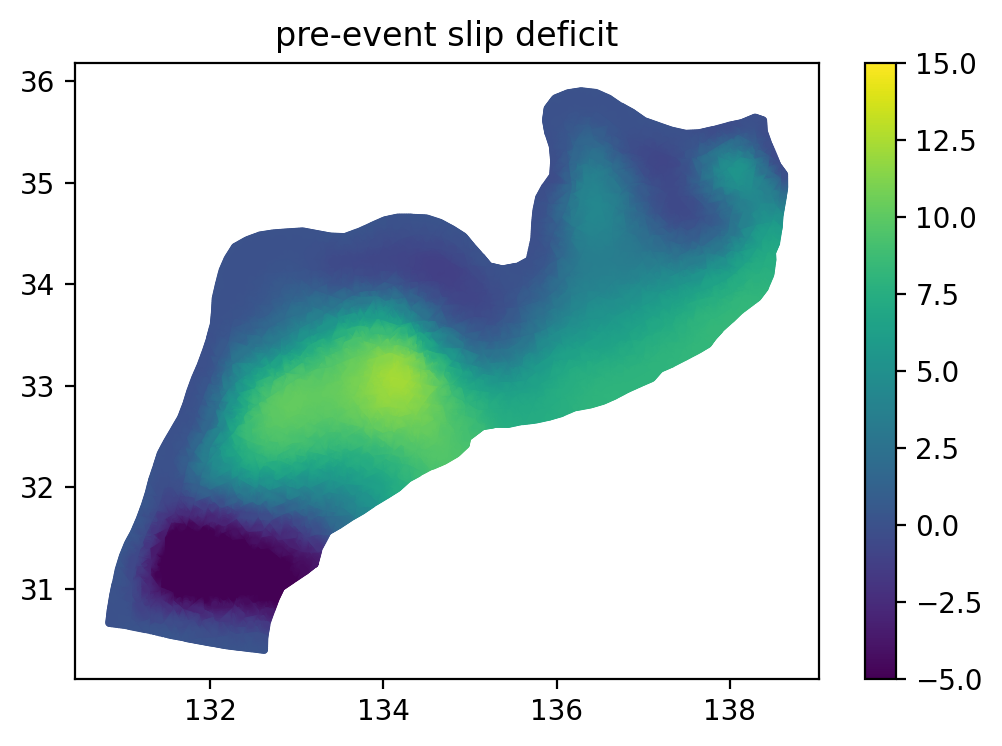

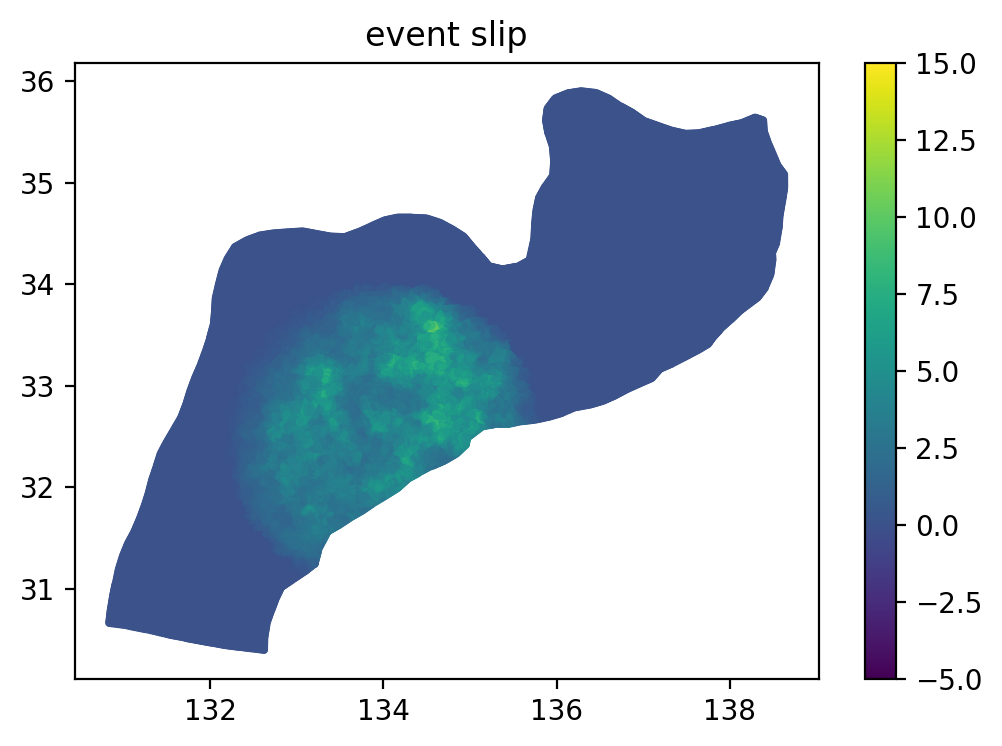

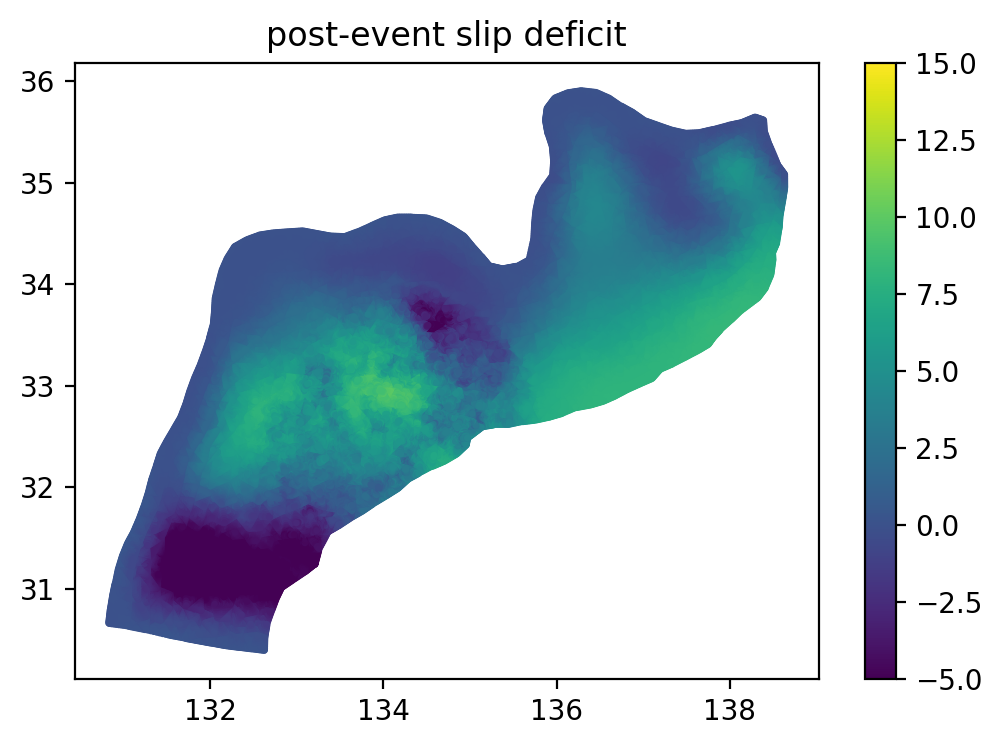

In [31]:
years = 200
MM_2_M = 1e-3
pre_event_slip_deficit = np.copy(initial_dip_slip_deficit)
pre_event_slip_deficit *= (MM_2_M * years)


post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=pre_event_slip_deficit, s=2
)
plt.colorbar()
plt.clim([-5, 15])
plt.title("pre-event slip deficit")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=event.slip_all_elements, s=2
)
plt.colorbar()
plt.clim([-5, 15])
plt.title("event slip")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(
    meshes[0].centroids[:, 0], meshes[0].centroids[:, 1], c=post_event_slip_deficit, s=2
)
plt.colorbar()
plt.clim([-5, 15])
plt.title("post-event slip deficit")
plt.show()


In [32]:
# Save relevant fields to a .npz file
np.savez(
    "skies_sign_step_erosion_figures_nankai.npz",
    name1=pre_event_slip_deficit,
    name2=event.slip_all_elements,
    name3=post_event_slip_deficit,
    name4=meshes[0].areas,
)

data = np.load("skies_sign_step_erosion_figures_nankai.npz")
print(data["name1"])
print(data["name2"])
print(data["name3"])
print(data["name4"])


[ 4.30828709  4.29188551  4.3656501  ... -0.10751098 -0.11213196
 -0.0919733 ]
[0. 0. 0. ... 0. 0. 0.]
[ 4.30828709  4.29188551  4.3656501  ... -0.10751098 -0.11213196
 -0.0919733 ]
[1608556.25189743 1608849.646951   1609120.60922733 ... 1810464.77220552
 1810283.76864549 1810789.64038059]


In [11]:
meshes[0].areas

array([1608556.25189743, 1608849.646951  , 1609120.60922733, ...,
       1810464.77220552, 1810283.76864549, 1810789.64038059])